# Homework - Bayesian modeling - Part A (100 points)
## Bayesian concept learning with the number game

by *Brenden Lake* and *Todd Gureckis*  
Computational Cognitive Modeling  
NYU class webpage: https://brendenlake.github.io/CCM-site/  

In this notebook, you will implement (mostly from scratch!) a Bayesian concept learning model and the "number game," as covered in lecture. As with so many of our everyday inferences, the data we receive is far too sparse and noisy to be conclusive. Nevertheless, people must make generalizations and take actions based on imperfect and insufficient data. In data science and machine learning, the situation is often the same: the data is not enough to produce an answer with certainty, yet we can make meaningful generalizations anyway. What computational mechanisms can support these types of inferences?

The number game is a quintessential inductive problem. In the number game, there is an unknown computer program that generates numbers in the range 1 to 100. You are provided with a small set of random examples from this program. For instance, in the figure below, you get two random examples from the program: the numbers '8' and '2'.

<img src="images/number_game_comp.jpeg" style="width: 300px;"/>

Which numbers will also be accepted by the same program? Of course, it depends what the program is, and you don't have enough information to be sure. Should '9' be accepted? Perhaps, if the concept is "all numbers up to 10." What about '10'? A better candidate, since the program could again be "numbers up to 10", or "all even numbers." What about '16'? This is another good candidate, and the program "powers of 2" is also consistent with the examples so far. How should one generalize based on the evidence so far? This homework explores how the Bayesian framework provides an answer to this question.

<div class="alert alert-info">
<h3>You should read the following paper carefully.</h3>
Josh Tenenbaum's paper introduced the number game. You can download the paper on EdStem:
<ul>
<li>Tenenbaum, J. B. (2000). Rules and similarity in concept learning. In Advances in Neural Information Processing Systems (NIPS).</li>
</ul>
</div>

### The Bayesian model
In the number game, we receive a set of $n$ positive examples $X = \{x^{(1)},...,x^{(n)}\}$ of an unknown concept $C$. In a Bayesian analysis of the task, the goal is predict $P(y \in C\ |\ X)$, which is the probability that a new number $y$ is also a member of the concept $C$ after receiving the set of examples $X$.

#### Updating beliefs with Bayes' rule
Let's proceed with the Bayesian model of the task. There is a hypothesis space $H$ of concepts, where a particular member of the hypothesis space (i.e., a particular concept) is denoted $h \in H$. The Bayesian model includes a prior distribution $P(h)$ over the hypotheses and a likelihood $P(X|h)$. Bayes' rule specifies how to compute the posterior distribution over hypotheses given these two pieces:
\begin{equation}
P(h|X) = \frac{P(X|h)P(h)}{\sum_{h' \in H} P(X|h')P(h')}
\end{equation}
The likelihood and prior are specified below.

#### Likelihood
We assume that each number in $X$ is an independent sample from the set of all valid numbers. Thus, the likelihood decomposes as a product of individual probabilities,
\begin{equation}
P(X|h) = \prod_{i=1}^n P(x^{(i)}|h).
\end{equation}
We assume that the numbers are sampled uniformly at random from the set of valid numbers, such that $P(x^{(i)}|h) = \frac{1}{|h|}$ if $x^{(i)} \in h$ and $P(x^{(i)}|h) = 0$ otherwise. The term $|h|$ is the cardinality or set size of the hypothesis $h$.

#### Prior
The hypothesis space $H$ includes two main kinds of hypotheses. You can think of each hypothesis as a list of the numbers that fit that hypothesis.
- The first kind consists of mathematical hypotheses such as odd numbers, even numbers, square numbers, cube numbers, primes, multiples of $n$, powers of $n$, and numbers ending with a particular digit. Each mathematical hypothesis is given equal weight in the prior.
- The second kind consists of interval hypotheses, which are solid intervals of numbers, such as $12, 13, 14, 15, 16, 17$. Intervals of intermediate size are favored (rather than very small or large hypotheses) by reweighting according to an Erlang distribution, $P(h) \propto \frac{|h|}{\sigma^2} \exp{-|h|/\sigma}$ such that $\sigma=10$.

There is a free parameters `mylambda` controls how much of the prior is specified by each type of hypothesis, with `mylambda` weight going to the mathematical hypotheses and `1-mylambda` weights going to the interval hypotheses.

We provide starter code below that generates the mathematical hypotheses and their prior probabilities (in natural log space).

#### Making Bayesian predictions
Once we have the posterior beliefs over hypotheses, we want to be able to make predictions about the membership of a new number $y$ in the concept $C$, or as mentioned $P(y \in C\ |\ X)$. To compute this, we average over all possible hypotheses weighted by the posterior probability,

\begin{equation}
P(y \in C\ |\ X) = \sum_{h \in H} P(y \in C\ |\ h) P(h|X),
\end{equation}

where the first term is simply $1$ or $0$ based on the membership of $y$ in h, and the second term is the posterior weight.

In [56]:
# Here are some packaegs that may be useful
from __future__ import print_function
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import logsumexp
x_max = 100 # (numbers between 1 and 100 are allowed)

In [57]:
# Generate a list of all mathematical hypotheses
def make_h_odd():
    return list(range(1,x_max+1,2))

def make_h_even():
    return list(range(2,x_max+1,2))

def make_h_square():
    h = []
    for x in range(1,x_max+1):
        if x**2 <= x_max:
            h.append(x**2)
    return h

def make_h_cube():
    h = []
    for x in range(1,x_max+1):
        if x**3 <= x_max:
            h.append(x**3)
    return h

def make_h_primes():
    return [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]

def make_h_mult_of_y(y):
    h = []
    for x in range(1,x_max+1):
        if x*y <= x_max:
            h.append(x*y)
    return h

def make_h_powers_of_y(y):
    h = []
    for x in range(1,x_max+1):
        if y**x <= x_max:
            h.append(y**x)
    return h

def make_h_numbers_ending_in_y(y):
    h = []
    for x in range(1,x_max+1):
        if str(x)[-1] == str(y):
            h.append(x)
    return h

def generate_math_hypotheses(mylambda):
    h_set = [make_h_odd(), make_h_even(), make_h_square(), make_h_cube(), make_h_primes()]
    h_set += [make_h_mult_of_y(y) for y in range(3,13)]
    h_set += [make_h_powers_of_y(y) for y in range(2,11)]
    h_set += [make_h_numbers_ending_in_y(y) for y in range(0,10)]
    n_hyp = len(h_set)
    log_prior = np.log(mylambda * np.ones(n_hyp) / float(n_hyp))
    return h_set, log_prior

h_set_math, log_prior_math = generate_math_hypotheses(2./3)
print("Four examples of math hypotheses:")
for i in range(4):
    print(h_set_math[i])
    print("")
print("Their prior log-probabilities:")
print(log_prior_math[0:4])

Four examples of math hypotheses:
[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99]

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100]

[1, 4, 9, 16, 25, 36, 49, 64, 81, 100]

[1, 8, 27, 64]

Their prior log-probabilities:
[-3.93182563 -3.93182563 -3.93182563 -3.93182563]


In [58]:
## Generate a list of all interval hypotheses
def make_h_between_y_and_z(y,z):
    assert(y >= 1 and z <= x_max)
    return list(range(y,z+1))

def pdf_erlang(x,sigma=10.):
    return (x / sigma**2) * np.exp(-x/sigma)

def generate_interval_hypotheses(mylambda):
    h_set = []
    for y in range(1,x_max+1):
        for z in range(y,x_max+1):            
            h_set.append(make_h_between_y_and_z(y,z))
    nh = len(h_set)
    pv = np.ones(nh)
    for idx,h in enumerate(h_set): # prior based on length
        pv[idx] = pdf_erlang(len(h))
    pv = pv / np.sum(pv)
    pv = (1-mylambda) * pv
    log_prior = np.log(pv)
    return h_set, log_prior

h_set_int, log_prior_int = generate_interval_hypotheses(2./3)
print("Four examples of interval hypotheses")
for i in range(4):
    print(h_set_int[i])
    print("")
print("Their prior log-probabilities:")
print(log_prior_int[0:4])

Four examples of interval hypotheses
[1]

[1, 2]

[1, 2, 3]

[1, 2, 3, 4]

Their prior log-probabilities:
[-10.197254    -9.60410682  -9.29864171  -9.11095964]


## Human behavioral judgments
Tenenbaum ran eight participants in an experiment where they were provided with various sets $X$ of random positive examples from a concept. They were asked to rate the probability that each of 30 test numbers would belong to the same concept of the observed examples. 

The following plot shows the mean rating across the human participants for three different sets. Note that since only 30 test numbers were evaluated, and thus a value of 0 in the plot indicates missing data (rather than zero probability).
<img src="images/number_game_human.jpeg" style="width: 800px;"/>

Your goal is to implement the Bayesian concept learning model in order to produce the same plots, although with the model judgements rather than the human judgements.

In [59]:
# The 30 test numbers that Tenenbaum used are here
x_eval = [2,4,6,8,9,10]+list(range(12,23))+[24,25,26,28,32,36,41,56,62,64,87,95,96]

## Implementation 
<div class="alert alert-success" role="alert">
<h3> Problem 1 (90 points) </h3>
<br>
Your main task is to produce the same three plots as shown above, although showing model predictions rather than human behavioral judgements. To do so, you'll need to implement the Bayesian concept learning model. A successful implementation will include the following components:
<ul>
    <li>A function for computing the log-probability of a hypothesis h according to the prior (largely provided in starter code).</li>
    <li>A function for computing the log-likelihood of a set of numbers X given a particular hypothesis h.</li>
    <li>A function for computing the log-posterior over all hypotheses h given a set of numbers X that were sampled from h.</li>
    <li>According to the "Making Bayesian predictions" section above, a function for computing the probability that a new number y belongs to the same concept as a set of sampled numbers X</li>
    <li>Code for making the plots</li>
</ul>
</div>

Tip: For probabilistic modeling in general, we like to compute probabilities in log-space to help avoid numerical issues such as underflow. For instance, rather than multiplying the prior and likelihood (resulting in potentially very small numbers), we sum the log-prior and the log-likelihood. Also, check out the nifty `logsumexp` function ([see scipy doc](https://docs.scipy.org/doc/scipy-0.19.0/reference/generated/scipy.misc.logsumexp.html)) which is used to normalize log-probability distributions in a numerically safer way. This function is already loaded.

In [60]:
# Your implementation goes here
import matplotlib.pyplot as plt
mylambda=2./3

#A function for computing the log-likelihood of a set of numbers X given a particular hypothesis h
# P(X|h) = P(D|theta)  p(2,4,6|even)=  (1/50)^3=(1/|h|)^|X|  to |X|*-log(|h|)
def log_likelihood(X,h):
    if set(X).issubset(set(h)):
        return -len(X)*np.log(len(h))
    else:
        return -999999

# A function for computing the log-posterior over all hypotheses h given a set of numbers X that were sampled from h
def log_posterior(X):
    #log prior probability
    h_set_math, log_prior_math = generate_math_hypotheses(mylambda)
    h_set_int, log_prior_int = generate_interval_hypotheses(1-mylambda)
    record=[]
    #P(h|X)
    for k in range(len(h_set_math)):
        h=h_set_math[k]
        log_prior=log_prior_math[k]
        record.append(log_prior+log_likelihood(X,h))
    for k in range(len(h_set_int)):
        h=h_set_int[k]
        log_prior=log_prior_int[k]
        record.append(log_prior+log_likelihood(X,h))
    A=np.exp(record)
    A2=np.log(np.sum(A))
    result=record-A2
    return h_set_math+h_set_int, result

#predict
def predict_result(y, X):
    hset, logp = log_posterior(X) 
    prob = 0
    y_int = int(y)  # Convert y to integer
    for k in range(len(hset)):
        h = hset[k]
        if y_int in h:
            value = 0  # y is in h, so no penalty
        else:
            value = -999999  
        prob += np.exp(logp[k] + value)
    predict = prob
    return predict

#making plot
def graph(X):
    ys=[1,]*x_max
    pred=[1,]*x_max
    for y in range(1,x_max+1):
        ys[y-1]=y
        pred[y-1]=predict_result(y,X)
    plt.figure(figsize=(16, 4))
    plt.bar(ys, pred,width=1)
    w=list(range(2,x_max+1,2))
    plt.xticks(w, w)
    plt.xlabel('Numbwe')
    plt.ylabel('probablity')
    plt.title('Data')
    plt.show()




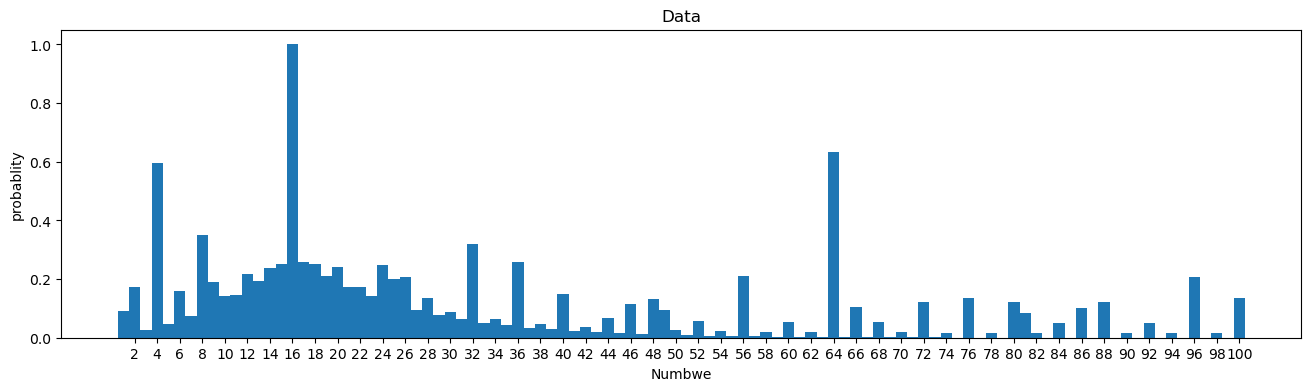

In [64]:
X=[16]
graph(X)

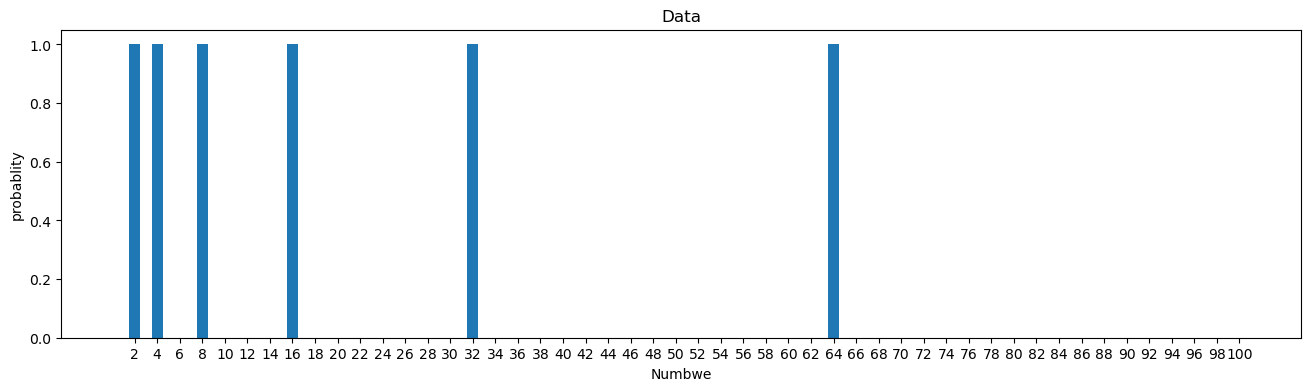

In [62]:
X=[16,8,2,64]
graph(X)

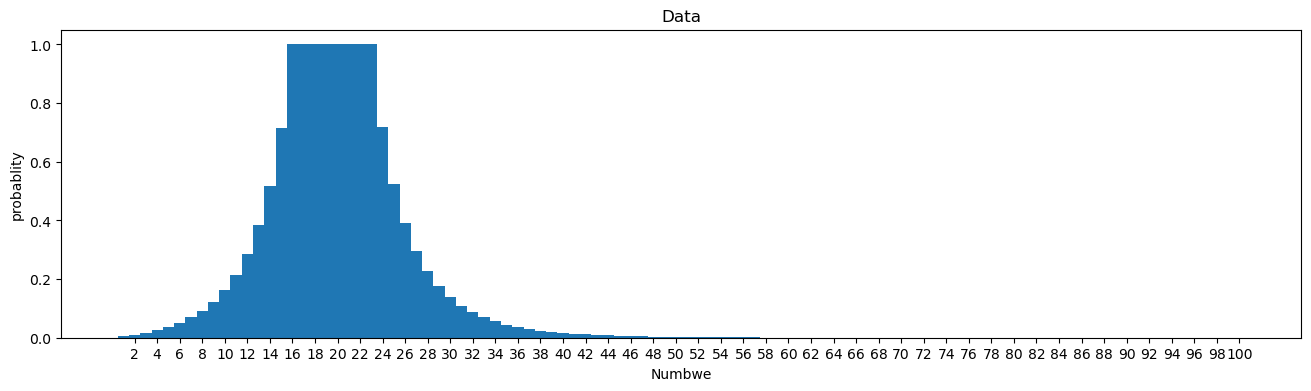

In [63]:
X=[16,23,19,20]
graph(X)

<div class="alert alert-success" role="alert">
<h3> Problem 2 (10 points) </h3>
<br>
Discuss your general thoughts on this Bayesian model to understand human judgments in the number game. Discussion questions could include the following (as well as others):
<ul>
    <li>Is the model convincing? Why or why not?</li>
    <li>Is the number game and Bayesian model relevant to more naturalistic settings for concept learning in childhood or everyday life?</li>
    <li>Where could the hypothesis space come from?</li>
    <li>What algorithms could people be using to approximate Bayesian inference, rather than enumerating all the hypotheses, as in the current implementation?</li>
</ul>
<br>
Please write a short response in the cell below. Your response should be about two paragraphs.
</div>

1. based on the theorm of Bayesian, we could know that the strength of the Bayesian framework lies in its formal mechanism of combining prior knowledge with new observations to make predictions.
This means the model is convince when human play the game without telling the length is 30. Because when people do not know the length of a particular concept, they must consider broader assumptions and interpret the observed data in complex or ambiguous situations. In this case, Bayesian models are more accurate because they are able to integrate and update various assumptions based on new evidence. But when humans know that a particular concept has a length of 30, they artificially narrow the hypothesis space down to matching only hypotheses of that length. The formal mechanism by which the case model combines prior knowledge with new observations to make predictions is similar to how humans think and therefore less convincing

2. Digital games and Bayesian models abstract some basic features of concept learning, such as the integration of prior knowledge with new information. Especially when I was young, I also learned enumeration method, inference method and other ways to complete the number game. These experiences are done through induction and inference.
But real-world concept learning is often more complex and less structured than digital games. Human accuracy is affected by emotions, biases, cognitive shortcuts (heuristics), and factors related to memory and attention, which is hard to be record in Bayesian models

3. Hypothetical Spaces can be derived from the study of how people classify and conceptualize objects. Such models are often derived from the model rules that humans tend to use in similar situations

4. Humans judge probabilities based on similarity to known categories, or based on easily recalled examples. I think of Markov chains. This algorithm is similar to Bayesian inference but does not require enumeration